In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import pickle
import re
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from scipy.stats import shapiro 
from scipy.stats import kstest
from scipy import interpolate
import math
import nolds

### load data from dataset

In [7]:
D1_data=pd.read_pickle('../data/dataset/D1_puregooddata_split_31032023.pkl')

In [8]:
class pain_monitering_D1:
    def __init__(self,PID):
        self.PID=PID
        self.D1_rating=[]
        self.D1_time=[]
        self.D1_prediction=-1
        self.D1_confidence=-1
    def __str__(self):
        print("participant: "+self.PID)
        print("Day 1 rating: "+str(len(self.D1_rating))+" sessions")
        print("Day 1 timing: "+str(len(self.D1_time))+" sessions")
        print("Day 1 prediction: "+ str(self.D1_prediction))
        print("Day 1 confidence: "+ str(self.D1_confidence))
        return ""
    def update_rating_time(self,rating,time):
        self.D1_rating=rating
        self.D1_time=time
    def update_prediction_confidence(self,pred,conf):
        self.D1_prediction=pred
        self.D1_confidence=conf

### load data into class

In [9]:
Day1_participant_list=[]
for i,pid in enumerate(D1_data['PID']):
    partcipant=pain_monitering_D1(pid)
    partcipant.update_rating_time(D1_data['rating'][i],D1_data['time'][i])
    partcipant.update_prediction_confidence(D1_data['prediction'][i],D1_data['confidence'][i])
    Day1_participant_list.append(partcipant)
print(str(len(Day1_participant_list))+" participants")

79 participants


### downsample to 40Hz (0.025 s)
+ original sampling rate is nearly 55 Hz

In [10]:
def downsample(rating, time,samplingrate):
    rating_downsample_list = []
    time_downsample_list = []
    for i in range(len(rating)):
        if len(rating[i]) > 1:
            original_timing = time[i]
            original_rating = rating[i]
            flinear = interpolate.interp1d(original_timing, original_rating)
            new_timing = np.arange(round_up(original_timing[0],1),round_down(original_timing[-1],1),1/samplingrate)
            ylinear = flinear(new_timing)
            rating_downsample_list.append(ylinear)
            time_downsample_list.append(new_timing)
        else:
            rating_downsample_list.append([np.nan])
            time_downsample_list.append([np.nan])
    return rating_downsample_list, time_downsample_list
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

In [11]:
downsample_rate=40

In [12]:
Day1_part_downsample_list=[]
for part in Day1_participant_list:
    partcipant=pain_monitering_D1(part.PID)
    partcipant.update_prediction_confidence(part.D1_prediction,part.D1_confidence)
    rating,time=downsample(part.D1_rating,part.D1_time,downsample_rate)
    partcipant.update_rating_time(rating,time)
    Day1_part_downsample_list.append(partcipant)

### the length of sliding window
+ the SampEn is significantly independent of the
time series length when the number of data points is larger than 750
+ temporary length: 200(5s)

In [13]:
def create_sliding_window2d(rating_list,time_list,window_length):
    rating_window_list=[]
    time_window_list=[]
    for j,rating in enumerate(rating_list):
        rating_window=[]
        time_window=[]
        for i in range(len(rating)-window_length+1):
            rating_window.append(rating[i:i+window_length])
            time_window.append(time_list[j][i:i+window_length])
        rating_window_list.append(np.array(rating_window))
        time_window_list.append(np.array(time_window))
    return rating_window_list,time_window_list

In [14]:
window_length=200

In [17]:
Day1_part_window2d_list_200=[]
for part in Day1_part_downsample_list:
    partcipant=pain_monitering_D1(part.PID)
    partcipant.update_prediction_confidence(part.D1_prediction,part.D1_confidence)
    rating,time=create_sliding_window2d(part.D1_rating,part.D1_time,window_length)
    partcipant.update_rating_time(rating,time)
    Day1_part_window2d_list_200.append(partcipant)

### data form
+ rating: 3+ matrix
+ each matrix: 200 * (281~4553)

In [16]:
# np.shape(Day1_part_window2d_list_200[0].D1_rating[0])
np.shape(Day1_part_window2d_list_200[0].D1_rating[0])

(4037, 200)

### test algorithm based on 1D data

In [109]:
def maxdist(vector_a,vector_b):
    return np.max([np.abs(vector_a-vector_b)])
def B_m(Matrix,m,r):
    length=np.shape(Matrix)[0]-m+1
    Matrix_window_list=[Matrix[i:i+m] for i in range(length)]
    D = np.zeros((length-1, length-1))
    for i in range(length-1):
        for j in range(i+1,length-1):
            if maxdist(Matrix_window_list[i],Matrix_window_list[j])<r:
                D[i,j]=1
                D[j,i]=D[i,j]
    count=np.sum(D)
    return count/((length-2)*(length-1))
    
def A_m(Matrix,m,r):
    length=np.shape(Matrix)[0]-m
    Matrix_window_list=[Matrix[i:i+m+1] for i in range(length)]
    D = np.zeros((length, length))
    for i in range(length):
        for j in range(i+1,length):
            if maxdist(Matrix_window_list[i],Matrix_window_list[j])<r:
                D[i,j]=1
                D[j,i]=D[i,j]
    count=np.sum(D)
    return count/((length-1)*length)
def SampEn_self(Matrix,m,r):
    r_std=np.std(Matrix)*r
    return -np.log(A_m(Matrix,m,r_std)/B_m(Matrix,m,r_std))

### generate test data

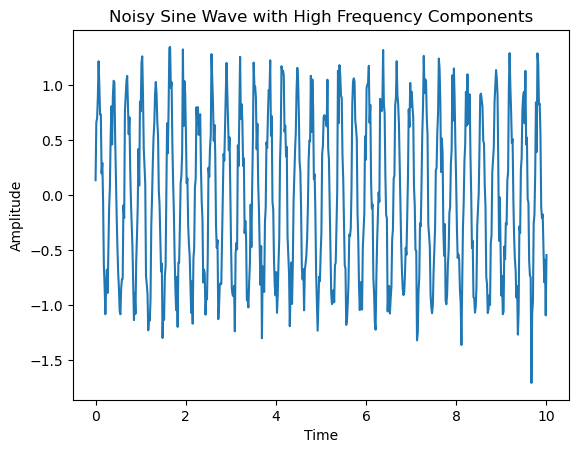

Sample Entropy from nolds: 1.3083928334533717
Sample Entropy by myself: 1.3083928334533717


In [110]:
t = np.linspace(0, 10, 600)
windowsize=500
data = np.sin(20 * t) + np.random.normal(0, 0.2, size=600)
length=np.shape(data)[0]-windowsize+1
data_list=[data[i:i+windowsize] for i in range(length)]
# Plot the time series
plt.plot(t, data)
plt.title("Noisy Sine Wave with High Frequency Components")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Print the sample entropy value
m=2
r=0.2* np.std(data)
sampen_nolds=nolds.sampen(data, emb_dim=m, tolerance=r)
print("Sample Entropy from nolds:", sampen_nolds)
sampen_self=SampEn_self(data,m,0.2)
print("Sample Entropy by myself:", sampen_self)

### calculate sample entropy for test data

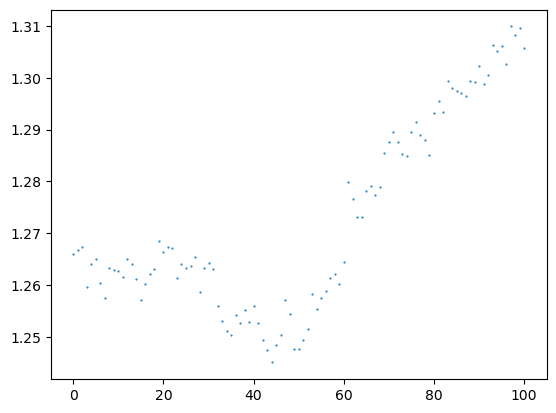

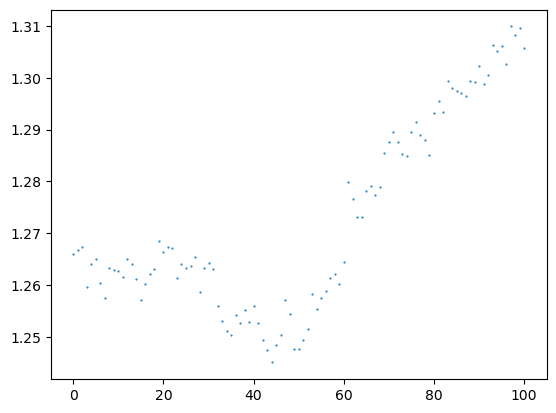

In [107]:
SampEn_nolds=[]
SampEn_self=[]
for i,d in enumerate(data_list):
    m=2
    r=0.2* np.std(d)
    SampEn_nolds.append(nolds.sampen(d, emb_dim=m, tolerance=r))
    SampEn_self.append(SampEn_self(d,2,0.2))
x_axis=np.arange(0,len(SampEn_nolds))
plt.scatter(x_axis, SampEn_nolds, s=0.3)
plt.show()
x_axis=np.arange(0,len(SampEn_self))
plt.scatter(x_axis, SampEn_self, s=0.3)
plt.show()

In [21]:
part_SampEn_list_200=[]
for part in tqdm(Day1_part_window2d_list_200):
    session_SampEn_list=[]
    for session in part.D1_rating:
        session_SampEn=[]
        for window in session:
            m=2
            r=0.2* np.std(window)
            session_SampEn.append(nolds.sampen(window,emb_dim=m, tolerance=r))
        session_SampEn_list.append(session_SampEn)
    part_SampEn_list_200.append(session_SampEn_list)
D1_data["entropy"]=part_SampEn_list_200
D1_data.to_pickle("../data/dataset/D1_data_entropy.pkl")

  0%|          | 0/79 [00:00<?, ?it/s]

In [176]:
session_SampEn_list=[]
for session in Day1_part_window2d_list_200[1].D1_rating:
    session_SampEn=[]
    for window in session:
        m=2
        r=0.2* np.std(window)
        session_SampEn.append(nolds.sampen(window,emb_dim=m, tolerance=r))
    session_SampEn_list.append(session_SampEn)

In [175]:
print(Day1_part_window2d_list_200[0].PID)

5cf4949170036500157cd383


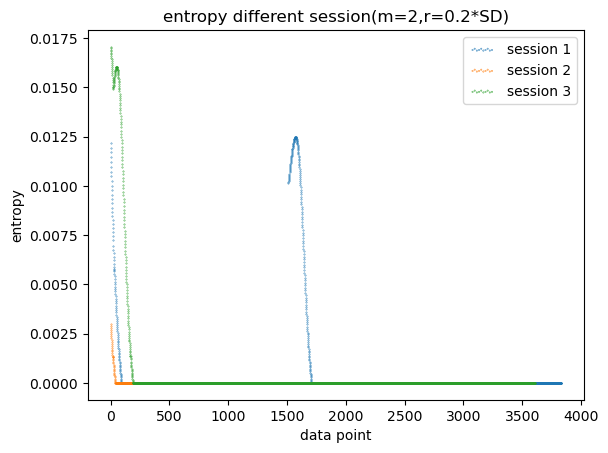

In [177]:
for i,session in enumerate(session_SampEn_list):
    plt.scatter(range(len(session)), session, s=0.1)
plt.legend(labels=['session 1','session 2','session 3'],loc='best',scatterpoints=10)
plt.title("entropy different session(m=2,r=0.2*SD)")
plt.xlabel("data point")
plt.ylabel("entropy")
plt.show()

In [162]:
np.shape(Day1_part_window2d_list_200[0].D1_rating[0][0])

(200,)

### change 1D entropy function to 2D data
+ solution: use Euclidean distance for windowed matrix

In [19]:
def Euclidean_distance(vector_a,vector_b):
    return np.sqrt(np.sum(np.square(vector_a-vector_b)))
def maxdist_2D(matrix_a, matrix_b):
    dist_list=[]
    for i in range(np.shape(matrix_a)[0]):
        dist_list.append(Euclidean_distance(matrix_a[i],matrix_b[i]))
    return np.max(dist_list)
def B_m_2D(Matrix,m,r):
    length=np.shape(Matrix)[0]-m+1
    Matrix_window_list=[Matrix[i:i+m] for i in range(length)]
    D = np.zeros((length-1, length-1))
    for i in range(length-1):
        for j in range(i+1,length-1):
            if maxdist_2D(Matrix_window_list[i],Matrix_window_list[j])<r:
                D[i,j]=1
                D[j,i]=D[i,j]
    count=np.sum(D)
    return count/((length-2)*(length-1))
def A_m_2D(Matrix,m,r):
    length=np.shape(Matrix)[0]-m
    Matrix_window_list=[Matrix[i:i+m+1] for i in range(length)]
    D = np.zeros((length, length))
    for i in range(length):
        for j in range(i+1,length):
            if maxdist_2D(Matrix_window_list[i],Matrix_window_list[j])<r:
                D[i,j]=1
                D[j,i]=D[i,j]
    count=np.sum(D)
    return count/((length-1)*length)
def SampEn2D(Matrix,m,r):
    r_std=np.std(Matrix)*r
    return -np.log(A_m_2D(Matrix,m,r_std)/B_m_2D(Matrix,m,r_std))

In [20]:
SampEn2D(Day1_part_window2d_list_200[0].D1_rating[0],2,0.2)

0.005825999961017618

In [21]:
np.shape(Day1_part_window2d_list_200[0].D1_rating[0])

(4037, 200)

In [122]:
m=2
r=0.2
SampEn2D_list=[]
for part in tqdm(Day1_part_window2d_list_200):
    SampEn2D_part=[]
    for session in part.D1_rating:
        SampEn2D_part.append(SampEn2D(session,m,r))
    SampEn2D_list.append(SampEn2D_part)
SampEn2D_list_all=[session for part in SampEn2D_list for session in part]
df_D1 = pd.DataFrame({'SampEn2D_list': SampEn2D_list})
df_D1.to_pickle("../data/dataset/2D_entropy.pkl")
df_D2 = pd.DataFrame({'SampEn2D_list_all': SampEn2D_list_all})
df_D2.to_pickle("../data/dataset/2D_entropy_all.pkl")

  0%|          | 0/79 [00:00<?, ?it/s]

C:\Users\28946\AppData\Local\Temp\ipykernel_8656\2604090196.py:28: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(A_m(Matrix,m,r_std)/B_m(Matrix,m,r_std))


In [123]:
window_length=300
Day1_part_window2d_list_300=[]
for part in Day1_part_downsample_list:
    partcipant=pain_monitering_D1(part.PID)
    partcipant.update_prediction_confidence(part.D1_prediction,part.D1_confidence)
    rating,time=create_sliding_window2d(part.D1_rating,part.D1_time,window_length)
    partcipant.update_rating_time(rating,time)
    Day1_part_window2d_list_300.append(partcipant)

In [126]:
m=2
r=0.2
SampEn2D_list_300=[]
for part in tqdm(Day1_part_window2d_list_300):
    SampEn2D_part=[]
    for session in part.D1_rating:
        SampEn2D_part.append(SampEn2D(session,m,r))
    SampEn2D_list_300.append(SampEn2D_part)
SampEn2D_list_all_300=[session for part in SampEn2D_list_300 for session in part]
df_D1_300 = pd.DataFrame({'SampEn2D_list_300': SampEn2D_list_300})
df_D1_300.to_pickle("../data/dataset/2D_entropy_300.pkl")
df_D2_300 = pd.DataFrame({'SampEn2D_list_all_300': SampEn2D_list_all_300})
df_D2_300.to_pickle("../data/dataset/2D_entropy_all_300.pkl")

  0%|          | 0/79 [00:00<?, ?it/s]

C:\Users\28946\AppData\Local\Temp\ipykernel_8656\2604090196.py:28: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(A_m(Matrix,m,r_std)/B_m(Matrix,m,r_std))


In [134]:
window_length=100
Day1_part_window2d_list_100=[]
for part in Day1_part_downsample_list:
    partcipant=pain_monitering_D1(part.PID)
    partcipant.update_prediction_confidence(part.D1_prediction,part.D1_confidence)
    rating,time=create_sliding_window2d(part.D1_rating,part.D1_time,window_length)
    partcipant.update_rating_time(rating,time)
    Day1_part_window2d_list_100.append(partcipant)

In [135]:
m=2
r=0.2
SampEn2D_list_100=[]
for part in tqdm(Day1_part_window2d_list_100):
    SampEn2D_part=[]
    for session in part.D1_rating:
        SampEn2D_part.append(SampEn2D(session,m,r))
    SampEn2D_list_100.append(SampEn2D_part)
SampEn2D_list_all_100=[session for part in SampEn2D_list_100 for session in part]
df_D1_100 = pd.DataFrame({'SampEn2D_list_100': SampEn2D_list_100})
df_D1_100.to_pickle("../data/dataset/2D_entropy_100.pkl")
df_D2_100 = pd.DataFrame({'SampEn2D_list_all_100': SampEn2D_list_all_100})
df_D2_100.to_pickle("../data/dataset/2D_entropy_all_100.pkl")

m=3
r=0.2
SampEn2D_list_m3=[]
for part in tqdm(Day1_part_window2d_list_200):
    SampEn2D_part=[]
    for session in part.D1_rating:
        SampEn2D_part.append(SampEn2D(session,m,r))
    SampEn2D_list_m3.append(SampEn2D_part)
SampEn2D_list_all_m3=[session for part in SampEn2D_list_m3 for session in part]
df_D1_m3 = pd.DataFrame({'SampEn2D_list_m3': SampEn2D_list_m3})
df_D1_m3.to_pickle("../data/dataset/2D_entropy_m3.pkl")
df_D2_m3 = pd.DataFrame({'SampEn2D_list_all_m3': SampEn2D_list_all_m3})
df_D2_m3.to_pickle("../data/dataset/2D_entropy_all_m3.pkl")

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

C:\Users\28946\AppData\Local\Temp\ipykernel_8656\2604090196.py:28: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(A_m(Matrix,m,r_std)/B_m(Matrix,m,r_std))


In [130]:
# Calculate pairwise distances between all points in the data array
def SampEn_2D_gpt(data,m,r):
    distances = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        for j in range(len(data)):
            distances[i,j] = np.linalg.norm(data[i]-data[j])

    # Calculate sample entropy with m=2 and r=0.2 (these are typical values)
    sample_entropy = nolds.sampen(distances, emb_dim=2, tolerance=0.2)
    return sample_entropy


In [ ]:
m=2
r=0.2
SampEn2D_list_300_gpt=[]
for part in tqdm(Day1_part_window2d_list_300):
    SampEn2D_part=[]
    for session in part.D1_rating:
        SampEn2D_part.append(SampEn_2D_gpt(session,m,r))
    SampEn2D_list_300_gpt.append(SampEn2D_part)
SampEn2D_list_all_300_gpt=[session for part in SampEn2D_list_300_gpt for session in part]
df_D1_300_gpt = pd.DataFrame({'SampEn2D_list_300_gpt': SampEn2D_list_300_gpt})
df_D1_300_gpt.to_pickle("../data/dataset/2D_entropy_300_gpt.pkl")
df_D2_300_gpt = pd.DataFrame({'SampEn2D_list_all_300_gpt': SampEn2D_list_all_300_gpt})
df_D2_300_gpt.to_pickle("../data/dataset/2D_entropy_all_300_gpt.pkl")
SampEn2D_list_200_gpt=[]
for part in tqdm(Day1_part_window2d_list_200):
    SampEn2D_part=[]
    for session in part.D1_rating:
        SampEn2D_part.append(SampEn_2D_gpt(session,m,r))
    SampEn2D_list_200_gpt.append(SampEn2D_part)
SampEn2D_list_all_200_gpt=[session for part in SampEn2D_list_200_gpt for session in part]
df_D1_200_gpt = pd.DataFrame({'SampEn2D_list_200_gpt': SampEn2D_list_200_gpt})
df_D1_200_gpt.to_pickle("../data/dataset/2D_entropy_200_gpt.pkl")
df_D2_200_gpt = pd.DataFrame({'SampEn2D_list_all_200_gpt': SampEn2D_list_all_200_gpt})
df_D2_200_gpt.to_pickle("../data/dataset/2D_entropy_all_200_gpt.pkl")

### entropy distribution
+ window length: 200 data point (5 s)

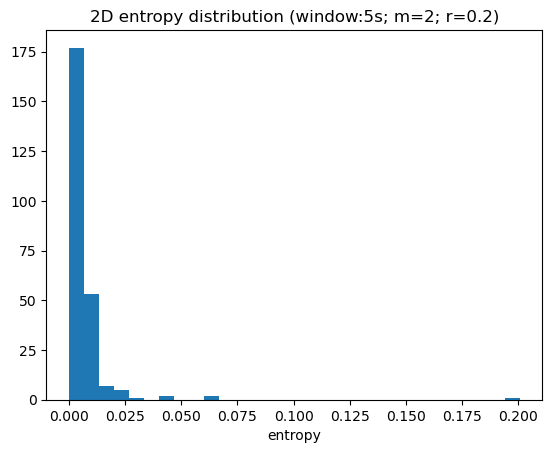

In [139]:
plt.xlabel("entropy")
plt.title("2D entropy distribution (window:5s; m=2; r=0.2)")
plt.hist(SampEn2D_list_all, bins=30)
plt.show()

In [200]:
# np.nanmean(SampEn2D_list_all)
np.nanstd(SampEn2D_list_all)

0.014602836338394317

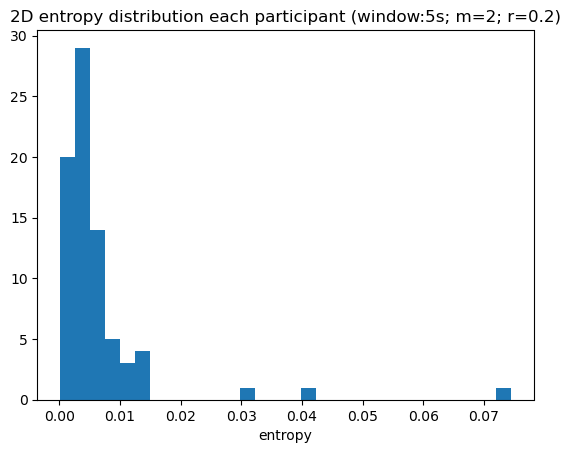

In [205]:
SampEn2D_part_list_200=[]
for part in SampEn2D_list:
    SampEn2D_part_list_200.append(np.mean(part))
plt.xlabel("entropy")
plt.title("2D entropy distribution each participant (window:5s; m=2; r=0.2)")
plt.hist(SampEn2D_part_list_200, bins=30)
plt.show()

In [206]:
np.nanmean(SampEn2D_part_list_200)
# np.nanstd(SampEn2D_part_list_200)

0.006497701928487369

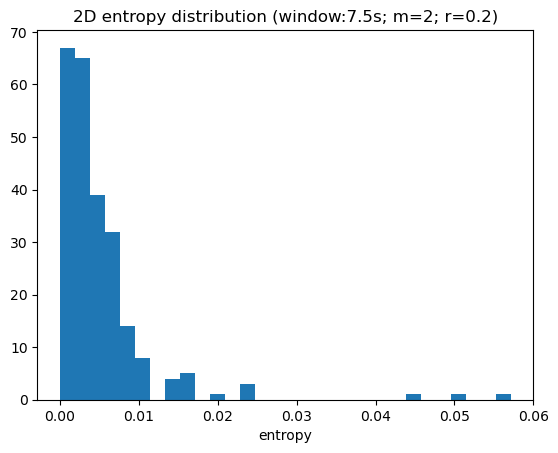

In [140]:
plt.xlabel("entropy")
plt.title("2D entropy distribution (window:7.5s; m=2; r=0.2)")
plt.hist(SampEn2D_list_all_300, bins=30)
plt.show()

In [208]:
np.nanmean(SampEn2D_list_all_300)
np.nanstd(SampEn2D_list_all_300)

0.006610481023536268

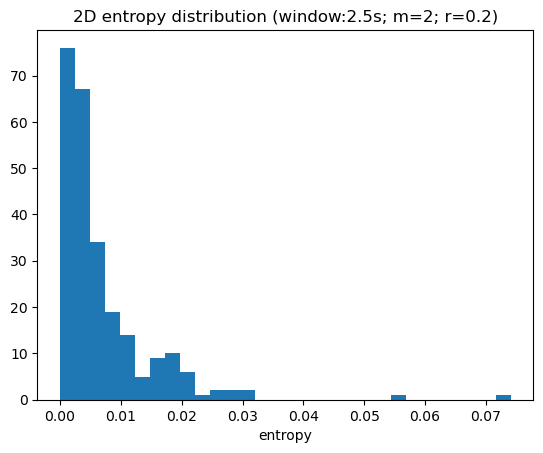

In [141]:
plt.xlabel("entropy")
plt.title("2D entropy distribution (window:2.5s; m=2; r=0.2)")
plt.hist(SampEn2D_list_all_100, bins=30)
plt.show()

In [210]:
np.nanmean(SampEn2D_list_all_100)
np.nanstd(SampEn2D_list_all_300)

0.006610481023536268

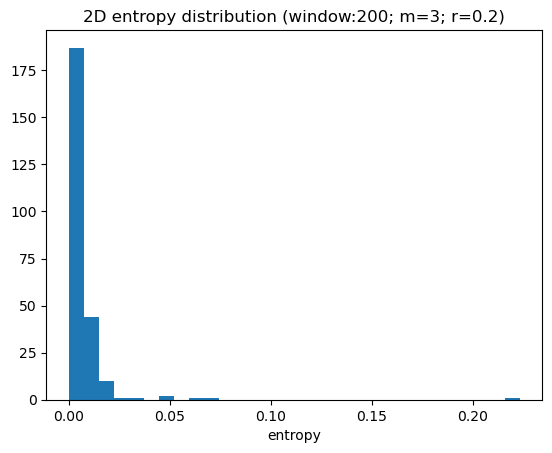

In [142]:
plt.xlabel("entropy")
plt.title("2D entropy distribution (window:200; m=3; r=0.2)")
plt.hist(SampEn2D_list_all_m3, bins=30)
plt.show()

In [211]:
def SampEn2D_avg1d(matrix, m,r):
    line_sampen_list=[]
    for line in matrix:
        r=0.2* np.std(line)
        line_sampen_list.append(nolds.sampen(line, emb_dim=m, tolerance=r))
    return np.mean(line_sampen_list)

In [157]:
SampEn2D_avg1d(Day1_part_window2d_list_200[0].D1_rating[0],2,0.2)

0.017186858894144025

In [159]:
r=0.2* np.std(Day1_part_window2d_list_200[0].D1_rating[0])
m=2
nolds.sampen(Day1_part_window2d_list_200[0].D1_rating[0],emb_dim=m, tolerance=r)

0.010582557194222995

In [215]:
m=2
r=0.2
SampEn2D_200_avg1d_list=[]
for part in tqdm(Day1_part_window2d_list_200):
    SampEn2D_part=[]
    for session in part.D1_rating:
        SampEn2D_part.append(SampEn2D_avg1d(session,m,r))
    SampEn2D_200_avg1d_list.append(SampEn2D_part)
SampEn2D_200_avg1d_list_all=[session for part in SampEn2D_200_avg1d_list for session in part]
df_D1 = pd.DataFrame({'SampEn2D_200_avg1d_list': SampEn2D_200_avg1d_list})
df_D1.to_pickle("../data/dataset/2D_entropy_avg1d_200.pkl")
df_D2 = pd.DataFrame({'SampEn2D_200_avg1d_list_all': SampEn2D_200_avg1d_list_all})
df_D2.to_pickle("../data/dataset/2D_entropy_all_avg1d_200.pkl")

  0%|          | 0/79 [00:00<?, ?it/s]